In [50]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.model_selection import train_test_split

In [51]:
((train_data, train_labels),
 (eval_data, eval_labels)) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
                                     """Data Augmentation using opencv"""

In [56]:
def translation_image(image):
    rows, cols ,c= image.shape
    M = np.float32([[1, 0, -5], [0, 1, -5]])
    image = cv2.warpAffine(image, M, (cols, rows))
    return image
    
def rotate_image(image):
    rows, cols,c = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), 30, 1)
    image = cv2.warpAffine(image, M, (cols, rows))
    return image

def rotate_image1(image):
    rows, cols,c = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), 90, 1)
    image = cv2.warpAffine(image, M, (cols, rows))
    return image

def flip_image_vertical(image):
    rows,cols,c = image.shape
    image= cv2.flip(image, 0)
    return image

def flip_image_horizontal(image):
    rows,cols,c = image.shape
    image= cv2.flip(image, 1)
    return image

def flip_image_both(image):
    rows,cols,c = image.shape
    image= cv2.flip(image, -1)
    return image



In [57]:
def Augmentation(img, n):
    if(n==0):
        return translation_image(img)
    elif(n==1):
            return rotate_image(img)
    elif(n==2):
            return rotate_image1(img)
    elif(n==3):
            return flip_image_vertical(img)
    elif(n==4):
            return flip_image_horizontal(img)
    elif(n==5):
            return flip_image_both(img)
    else:
        return img

In [58]:
Title = ["translation_image","rotate_image","rotate_image1","flip_image_vertical","flip_image_horizontal","flip_image_both"]

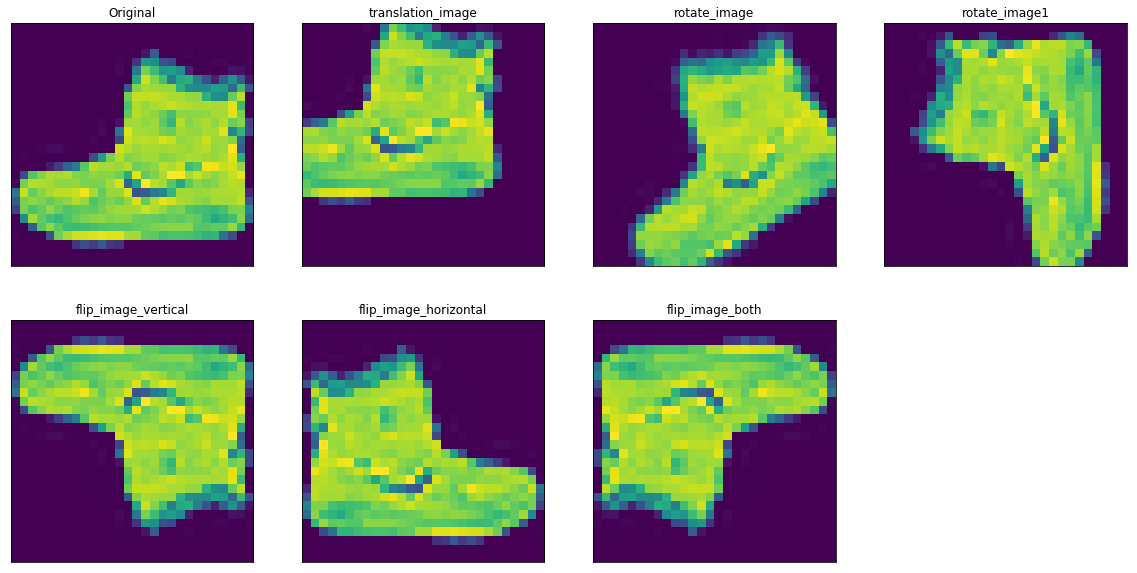

In [59]:
plt.figure(figsize=(20,10))
plt.subplot(2,4,1)
plt.imshow(train_data[0,:,:])
plt.xticks([])
plt.yticks([])
plt.title("Original")

for i in range(6):
    plt.subplot(2,4,i+2)
    imx = Augmentation(train_data[0,:,:].reshape(28,28,1),i)
    plt.imshow(imx.reshape(28,28))
    plt.xticks([])
    plt.yticks([])
    plt.title(Title[i])

In [31]:
target_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot',
}

In [32]:
print(train_data.shape)
print(eval_data.shape)

(60000, 28, 28)
(10000, 28, 28)


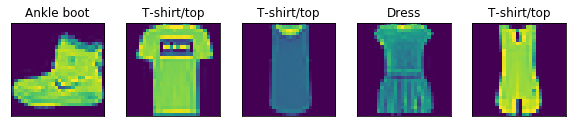

In [33]:
plt.figure(figsize=(10,10))
for i in range(0,5):
    plt.subplot(5,5, i+1)
    plt.imshow(train_data[i] )
    plt.title( target_dict[(train_labels[i]) ])
    plt.xticks([])
    plt.yticks([])

In [34]:
train_data = train_data/np.float32(255)
train_labels = train_labels.astype(np.int32)

eval_data = eval_data/np.float32(255)
eval_labels = eval_labels.astype(np.int32)

In [35]:
def cnn_model(features, labels, mode):
    #Reshapinng the input
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
    
     # Convolutional Layer #1 and Pooling Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    
    # Convolutional Layer #3 and Pooling Layer #3
    conv3 = tf.layers.conv2d(
          inputs=pool2,
          filters=128,
          kernel_size=[5, 5],
        
          padding="same",
          activation=tf.nn.relu)
    
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
    
       
    flatten_1= tf.reshape(pool3, [-1, 3*3*128])
    
    dense = tf.layers.dense(inputs= flatten_1,units=1024,activation=tf.nn.relu)
    
    
    output_layer = tf.layers.dense(inputs= dense, units=10)
    predictions={
    "classes":tf.argmax(input=output_layer, axis=1),
    "probabilities":tf.nn.softmax(output_layer,name='softmax_tensor')
    }
    if mode==tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loss= tf.losses.sparse_softmax_cross_entropy(labels=labels, logits= output_layer, scope='loss')
    
    if mode== tf.estimator.ModeKeys.TRAIN:
        optimizer= tf.train.AdamOptimizer(learning_rate=0.001)
        train_op= optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss,train_op=train_op )
    
    eval_metrics_op={ "accuracy":tf.metrics.accuracy(labels=labels,predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metrics_op)

In [36]:
fashion_classifier = tf.estimator.Estimator(model_fn = cnn_model)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp0a44t02j', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6c6cfb8400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [37]:
# Training the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

fashion_classifier.train(input_fn=train_input_fn, steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp0a44t02j/model.ckpt.
INFO:tensorflow:loss = 2.299216, step = 1
INFO:tensorflow:global_step/sec: 3.92159
INFO:tensorflow:loss = 0.52140075, step = 101 (25.502 sec)
INFO:tensorflow:global_step/sec: 3.4296
INFO:tensorflow:loss = 0.2959625, step = 201 (29.157 sec)
INFO:tensorflow:global_step/sec: 3.96467
INFO:tensorflow:loss = 0.55060923, step = 301 (25.223 sec)
INFO:tensorflow:global_step/sec: 3.87986
INFO:tensorflow:loss = 0.32913443, step = 401 (25.775 sec)
INFO:tensorflow:global_step/sec: 3.58237
INFO:tensorflow:loss = 0.14700368, step = 501 (27.915 sec)
INFO:tensorflow:global_step/sec: 3.76662
INFO:tensorflow:loss = 0.39883283, step = 601 (26.548 sec)
INFO:tensorflow:global_step/sec: 4.12666
INFO:te

In [38]:
#Evaluation using test data
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)

eval_results = fashion_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17T08:47:22Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0a44t02j/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-08:47:30
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.8865, global_step = 1000, loss = 0.30862167
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmp0a44t02j/model.ckpt-1000
{'accuracy': 0.8865, 'loss': 0.30862167, 'global_step': 1000}


In [47]:
********************************CNN Model with dropout*******************************************************************


In [39]:
def cnn_model_dp(features, labels, mode):
    #Reshapinng the input
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
    
     # Convolutional Layer #1 and Pooling Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
    
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[3, 3],
          padding="same",
          activation=tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    dropout_1 = tf.layers.dropout(inputs=pool2, rate=0.25,training=mode == tf.estimator.ModeKeys.TRAIN )
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv3 = tf.layers.conv2d(
          inputs=dropout_1,
          filters=128,
          kernel_size=[3, 3],
        
          padding="same",
          activation=tf.nn.relu)
    
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
    
    dropout_2 = tf.layers.dropout(inputs=pool3, rate=0.25,training=mode == tf.estimator.ModeKeys.TRAIN )
       
    flatten_1= tf.reshape(dropout_2, [-1, 3*3*128])
    
    dense = tf.layers.dense(inputs= flatten_1,units=1024,activation=tf.nn.relu)
    
    dropout= tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    output_layer = tf.layers.dense(inputs= dropout, units=10)
    predictions={
    "classes":tf.argmax(input=output_layer, axis=1),
    "probabilities":tf.nn.softmax(output_layer,name='softmax_tensor')
    }
    if mode==tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loss= tf.losses.sparse_softmax_cross_entropy(labels=labels, logits= output_layer, scope='loss')
    
    if mode== tf.estimator.ModeKeys.TRAIN:
        optimizer= tf.train.AdamOptimizer(learning_rate=0.001)
        train_op= optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss,train_op=train_op )
    
    eval_metrics_op={ "accuracy":tf.metrics.accuracy(labels=labels,predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metrics_op)

In [40]:
fashion_classifier_dp = tf.estimator.Estimator(model_fn = cnn_model_dp)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpriud5sec', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6c6cfb8160>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [41]:
# Training of the model
train_input_fn_dp = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

fashion_classifier_dp.train(input_fn=train_input_fn_dp, steps=1500)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpriud5sec/model.ckpt.
INFO:tensorflow:loss = 2.3203166, step = 1
INFO:tensorflow:global_step/sec: 8.8502
INFO:tensorflow:loss = 0.40502796, step = 101 (11.300 sec)
INFO:tensorflow:global_step/sec: 11.187
INFO:tensorflow:loss = 0.6083163, step = 201 (8.939 sec)
INFO:tensorflow:global_step/sec: 11.1185
INFO:tensorflow:loss = 0.3506944, step = 301 (8.994 sec)
INFO:tensorflow:global_step/sec: 11.1564
INFO:tensorflow:loss = 0.5222387, step = 401 (8.964 sec)
INFO:tensorflow:global_step/sec: 11.1671
INFO:tensorflow:loss = 0.48991668, step = 501 (8.955 sec)
INFO:tensorflow:global_step/sec: 11.1549
INFO:tensorflow:loss = 0.3850027, step = 601 (8.964 sec)
INFO:tensorflow:global_step/sec: 10.9872
INFO:tensorflow

In [42]:
#Evaluation using test data
eval_input_fn_dp = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)

eval_results_dp = fashion_classifier_dp.evaluate(input_fn=eval_input_fn_dp)
print(eval_results_dp)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17T08:51:55Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpriud5sec/model.ckpt-1500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-08:51:57
INFO:tensorflow:Saving dict for global step 1500: accuracy = 0.891, global_step = 1500, loss = 0.29371423
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1500: /tmp/tmpriud5sec/model.ckpt-1500
{'accuracy': 0.891, 'loss': 0.29371423, 'global_step': 1500}


In [ ]:
******************************CNN Model with batch normalization********************************************************

In [43]:

def cnn_model_batchnorm(features, labels, mode):
    #Reshapinng the input
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
    
     # Convolutional Layer #1 and Pooling Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same")
    conv1= tf.layers.batch_normalization(conv1)
    conv1=tf.nn.relu(conv1)
    
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[5, 5],
          padding="same")
    conv2= tf.layers.batch_normalization(conv2)
    conv2=tf.nn.relu(conv2)
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    
    # Convolutional Layer #3 and Pooling Layer #3
    conv3 = tf.layers.conv2d(
          inputs=pool2,
          filters=128,
          kernel_size=[5, 5],
          padding="same")
    conv3= tf.layers.batch_normalization(conv3)
    conv3=tf.nn.relu(conv3)
    
    
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
    
       
    flatten_1= tf.reshape(pool3, [-1, 3*3*128])
    
    dense = tf.layers.dense(inputs= flatten_1,units=1024)
    dense = tf.layers.batch_normalization(dense)
    dense=tf.nn.relu(dense)
    
    
    output_layer = tf.layers.dense(inputs= dense, units=10)
    predictions={
    "classes":tf.argmax(input=output_layer, axis=1),
    "probabilities":tf.nn.softmax(output_layer,name='softmax_tensor')
    }
    if mode==tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loss= tf.losses.sparse_softmax_cross_entropy(labels=labels, logits= output_layer, scope='loss')
    
    if mode== tf.estimator.ModeKeys.TRAIN:
        optimizer= tf.train.AdamOptimizer(learning_rate=0.001)
        train_op= optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss,train_op=train_op )
    
    eval_metrics_op={ "accuracy":tf.metrics.accuracy(labels=labels,predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metrics_op)

In [44]:
fashion_classifier_batchnorm = tf.estimator.Estimator(model_fn = cnn_model_batchnorm)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp4ui7eipj', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6c81848780>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [45]:
# Train the model
train_input_fn_batchnorm = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

fashion_classifier_batchnorm.train(input_fn=train_input_fn_batchnorm, steps=1500)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp4ui7eipj/model.ckpt.
INFO:tensorflow:loss = 2.3012419, step = 1
INFO:tensorflow:global_step/sec: 5.03875
INFO:tensorflow:loss = 0.59611297, step = 101 (19.847 sec)
INFO:tensorflow:global_step/sec: 4.46427
INFO:tensorflow:loss = 0.36538112, step = 201 (22.400 sec)
INFO:tensorflow:global_step/sec: 3.87626
INFO:tensorflow:loss = 0.4075945, step = 301 (25.798 sec)
INFO:tensorflow:global_step/sec: 4.14054
INFO:tensorflow:loss = 0.5438215, step = 401 (24.151 sec)
INFO:tensorflow:global_step/sec: 4.50264
INFO:tensorflow:loss = 0.4295908, step = 501 (22.209 sec)
INFO:tensorflow:global_step/sec: 4.48227
INFO:tensorflow:loss = 0.3363175, step = 601 (22.310 sec)
INFO:tensorflow:global_step/sec: 4.01026
INFO:ten

In [46]:
#Evaluation using test data
eval_input_fn_batchnorm = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)

eval_results_batchnorm = fashion_classifier_batchnorm.evaluate(input_fn=eval_input_fn_batchnorm)
print(eval_results_batchnorm)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17T08:59:58Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp4ui7eipj/model.ckpt-1500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-17-09:00:03
INFO:tensorflow:Saving dict for global step 1500: accuracy = 0.9071, global_step = 1500, loss = 0.25867996
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1500: /tmp/tmp4ui7eipj/model.ckpt-1500
{'accuracy': 0.9071, 'loss': 0.25867996, 'global_step': 1500}
